# Exercise 1

## Imports

In [71]:
from io import SEEK_CUR
import os.path as path
import pandas as pd
import gzip
import numpy as np

## Prepare the data

In [2]:
high_energy_dataset = 'ca-HepPh.txt.gz'
facebook_dataset = 'facebook_combined.txt.gz'
pathways_dataset = 'PP-Pathways_ppi.csv.gz'
data_folder = 'data'

In [3]:
def load_dataset(dataset: str, data_folder: str = data_folder) -> pd.DataFrame:
    pt = path.join(data_folder, dataset)
    
    if dataset == 'ca-HepPh.txt.gz':
        with gzip.open(pt, 'rb') as f:
            c = f.read(1)
            while c == b'#':
                f.readline()
                c = f.read(1)
            f.seek(-1, SEEK_CUR)
            return pd.read_csv(f, sep='\t', header=None)
        
    elif dataset == 'facebook_combined.txt.gz':
        return pd.read_csv(pt, sep=' ', header=None)

    return pd.read_csv(pt, header=None)

In [4]:
dataset = load_dataset(facebook_dataset).rename(columns={0: 'source', 1: 'target'})

## Our implementation

In [5]:
# TODO

### Create the Laplacian matrix

In [82]:
graph = nx.from_pandas_edgelist(dataset, source='source', target='target')

laplacian_matrix = nx.laplacian_matrix(graph).todense()

### Decomposition (find eigenvalues and eigenvectors of L)

In [78]:
eigenvalues, eigenvectors = np.linalg.eig(laplacian_matrix)

In [93]:
eigenvalues = np.sort(eigenvalues)

In [98]:
eigenvectors[1]

array([-0.4268344 +0.j, -0.35272136+0.j, -0.25619816+0.j, ...,
        0.21983773+0.j,  0.22050817+0.j,  0.31643176+0.j])

In [6]:
n_clusters_ideal = 8    # TODO: choose an appropriate value

## Scikit-learn Spectral Clustering

In [49]:
from sklearn.cluster import SpectralClustering

SpectralClustering(n_clusters_ideal, eigen_solver='lobpcg').fit(dataset[:10000])

/home/pedro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/pedro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited at iteration 222 with accuracies 
[6.45015821e-16 1.47744046e-04 1.18306203e-04 1.12458841e-04
 1.72622935e-04 1.47823553e-04 1.34965683e-04 1.66825197e-04
 1.38041756e-04]
not reaching the requested tolerance 0.00014901161193847656.
Use iteration 221 instead with accuracy 
0.0001263786621753157.

  _, diffusion_map = lobpcg(
/home/pedro/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited postprocessing with accuracies 
[1.79546494e-15 1.47736784e-04 1.19011852e-04 1.12397541e-04
 1.74309190e-04 1.48467073e-04 1.34838126e-04 1.49246502e-04
 1.51400891e-04]
not reaching the requested tolerance 0.00014901161193847656.
  _, diffusion_map 

SpectralClustering(eigen_solver='lobpcg')

## Spark Power Iteration Clustering

In [8]:
from pyspark.ml.clustering import PowerIterationClustering
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

spark = SparkSession.builder \
    .appName('SpectralClustering') \
    .config('spark.master', 'local[*]') \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/24 14:41:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [9]:
dataset_spark = spark.createDataFrame(dataset)

Add the weight column (all at 1s).

In [10]:
dataset_spark = dataset_spark.withColumn('weight', F.lit(1))

In [11]:
pic = PowerIterationClustering(k=2, maxIter=20, initMode="degree", srcCol='source', dstCol='target', weightCol="weight")
dataset_clustered = pic.assignClusters(dataset_spark).toPandas()

23/05/24 14:41:47 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


## Visualization

In [14]:
import networkx as nx

g = nx.from_pandas_edgelist(dataset.sample(1000), create_using=nx.DiGraph)

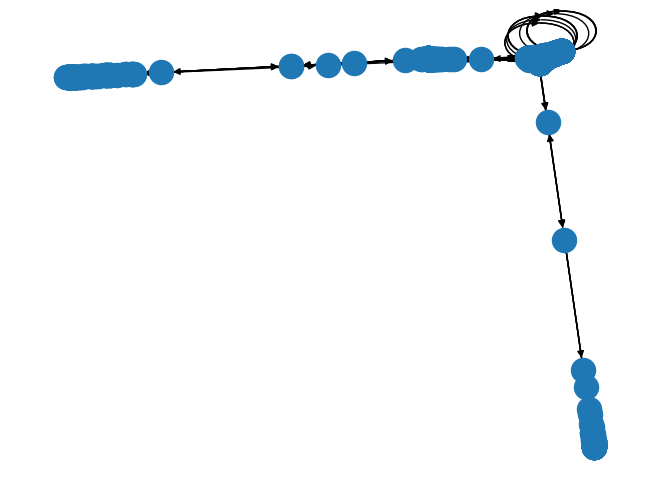

In [15]:
nx.draw_spectral(nx.from_pandas_edgelist(dataset, create_using=nx.DiGraph))

In [16]:
colors = [dataset_clustered[dataset_clustered['id'] == node]['cluster'].values[0] for node in g.nodes]

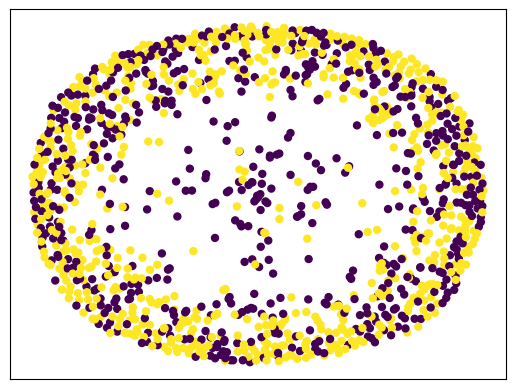

In [17]:
nx.draw_networkx(g, edgelist=[], arrows=False, node_size=25, with_labels=False, node_color=colors)